In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
import string 

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf 
import keras
from keras.preprocessing import text,sequence
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout

from bs4 import BeautifulSoup
from nltk.corpus import stopwords  
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import pickle

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv


##### Importing Data

In [2]:
real_data = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/True.csv')
fake_data = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv')

In [3]:
real_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
real_data['label'] = 1
fake_data['label'] = 0 

In [6]:
#Merging the 2 datasets
data = pd.concat([real_data, fake_data], ignore_index=True, sort=False)
data.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [7]:
data.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

##### Visualizations

0    23481
1    21417
Name: label, dtype: int64


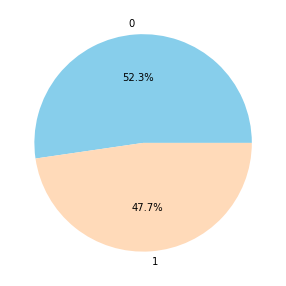

In [8]:
print(data["label"].value_counts())
fig, ax = plt.subplots(figsize=(19, 5))
g2 = plt.pie(data["label"].value_counts().values,explode=[0,0],labels=data.label.value_counts().index, autopct='%1.1f%%',colors=['SkyBlue','PeachPuff'])
fig.show()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64


Text(0.5, 1.0, 'Distribution of The Subject According to Real and Fake Data')

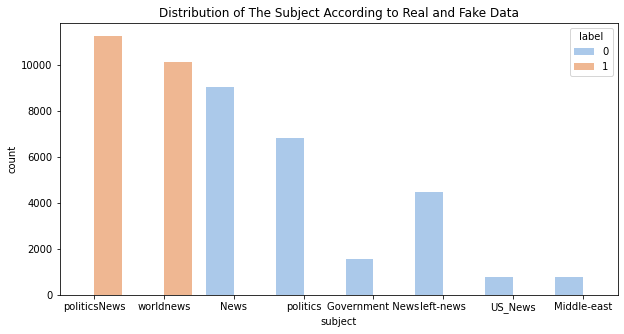

In [9]:
print(data.subject.value_counts())
plt.figure(figsize=(10, 5))

ax = sns.countplot(x="subject",  hue='label', data=data, palette="pastel")
plt.title("Distribution of The Subject According to Real and Fake Data")

##### Data Cleaning

In [10]:
data['text']= data['subject'] + " " + data['title'] + " " + data['text']
del data['title']
del data['subject']
del data['date']
data.head()

,text,label
0,"politicsNews As U.S. budget fight looms, Repub...",1
1,politicsNews U.S. military to accept transgend...,1
2,politicsNews Senior U.S. Republican senator: '...,1
3,politicsNews FBI Russia probe helped by Austra...,1
4,politicsNews Trump wants Postal Service to cha...,1


In [11]:
# A text example 
text_ex = data.text[0]
text_ex

'politicsNews As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional incr

##### Preprocessing Data

In [12]:
nltk.download("omw-1.4")

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [13]:
#Removal of HTML Contents
def remove_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removal of Punctuation Marks
def remove_punctuations(text):
    return re.sub('\[[^]]*\]', '', text)

# Removal of Special Characters
def remove_characters(text):
    return re.sub("[^a-zA-Z]"," ",text)

#Removal of stopwords 
def remove_stopwords_and_lemmatization(text):
    final_text = []
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    for word in text:
        if word not in set(stopwords.words('english')):
            lemma = nltk.WordNetLemmatizer()
            word = lemma.lemmatize(word) 
            final_text.append(word)
    return " ".join(final_text)

#Total function
def cleaning(text):
    text = remove_html(text)
    text = remove_punctuations(text)
    text = remove_characters(text)
    text = remove_stopwords_and_lemmatization(text)
    return text

#Apply function on text column
data['text']=data['text'].apply(cleaning)

In [14]:
data.head()

,text,label
0,politicsnews u budget fight loom republican fl...,1
1,politicsnews u military accept transgender rec...,1
2,politicsnews senior u republican senator let m...,1
3,politicsnews fbi russia probe helped australia...,1
4,politicsnews trump want postal service charge ...,1


##### Visualizations on New Data

###### WordCloud for Real News

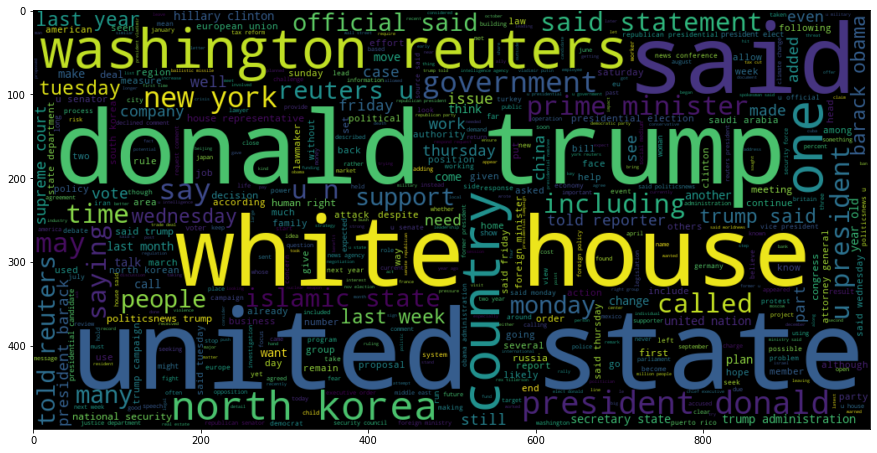

In [15]:
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 500 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(data[data.label == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

###### WordCloud for Fake News

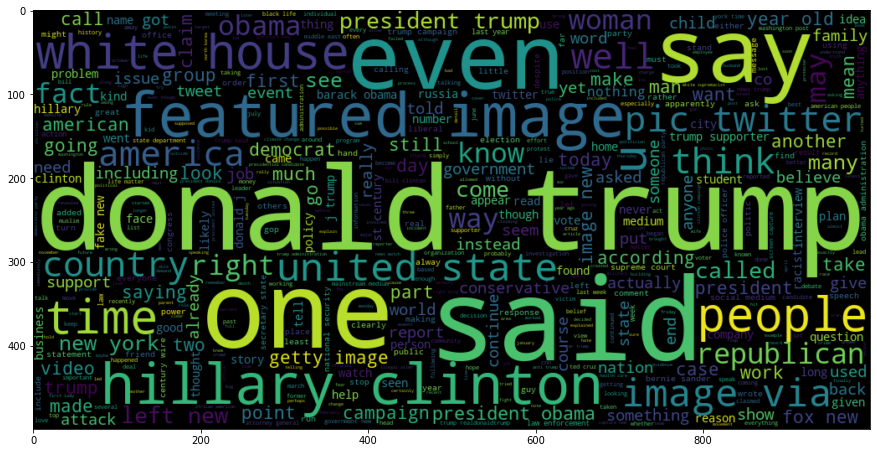

In [16]:
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 500 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(data[data.label == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

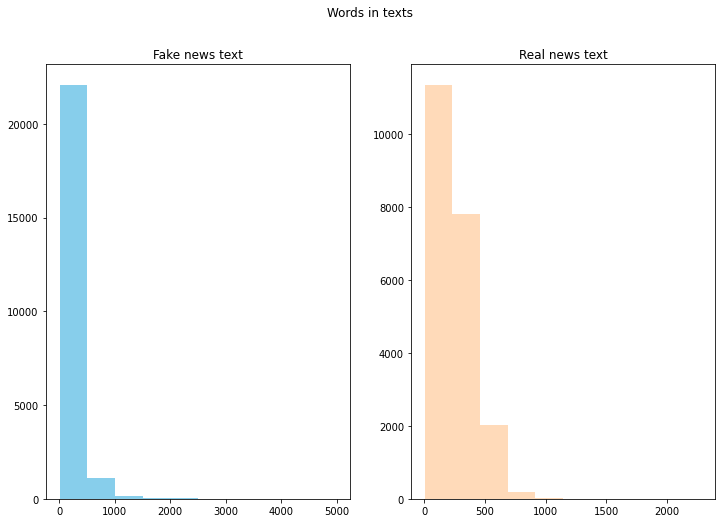

In [17]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=data[data['label']==0]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='SkyBlue')
ax1.set_title('Fake news text')
text_len=data[data['label']==1]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='PeachPuff')
ax2.set_title('Real news text')
fig.suptitle('Words in texts')
plt.show()

##### N Gram Analysis

In [18]:
texts = ' '.join(data['text'])
string = texts.split(" ")
def draw_n_gram(string,i):
    n_gram = (pd.Series(nltk.ngrams(string, i)).value_counts())[:15]
    n_gram_df=pd.DataFrame(n_gram)
    n_gram_df = n_gram_df.reset_index()
    n_gram_df = n_gram_df.rename(columns={"index": "word", 0: "count"})
    print(n_gram_df.head())
    plt.figure(figsize = (16,9))
    return sns.barplot(x='count',y='word', data=n_gram_df)

###### Unigram Analysis

           word   count
0      (trump,)  149603
1       (said,)  133030
2          (u,)   78516
3      (state,)   62726
4  (president,)   58790


<AxesSubplot:xlabel='count', ylabel='word'>

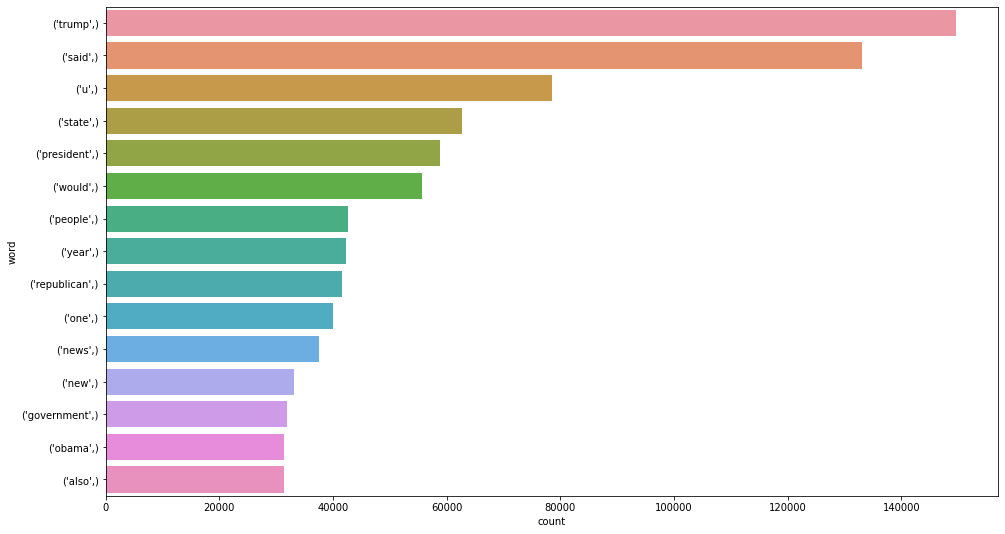

In [19]:
draw_n_gram(string,1)

###### Bigram Analysis

                 word  count
0     (donald, trump)  25203
1     (united, state)  18943
2      (white, house)  16296
3  (hillary, clinton)  10217
4         (new, york)   9305


<AxesSubplot:xlabel='count', ylabel='word'>

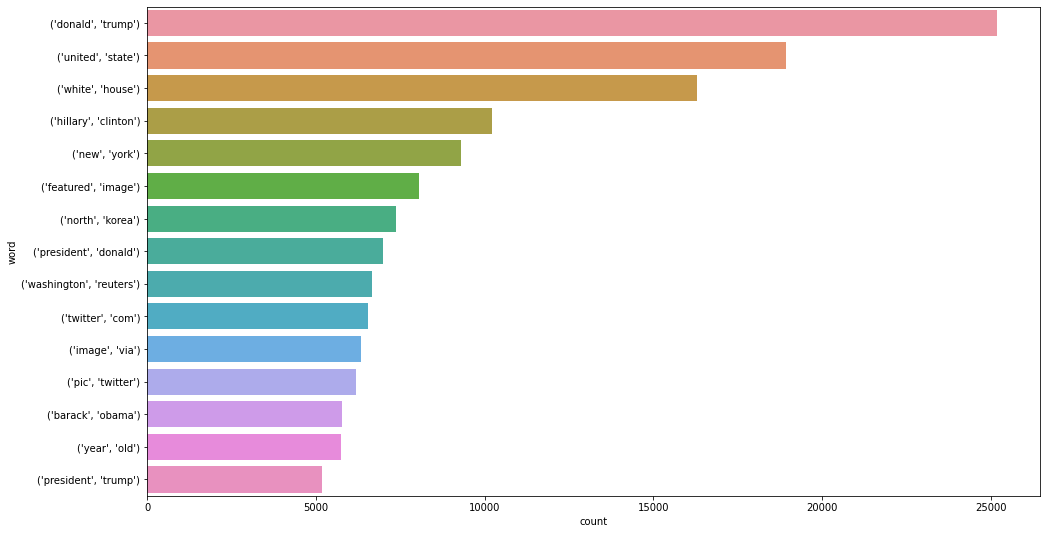

In [20]:
draw_n_gram(string,2)

###### Trigram Analysis

                         word  count
0  (president, donald, trump)   6830
1         (pic, twitter, com)   6185
2      (featured, image, via)   6029
3  (president, barack, obama)   3911
4        (getty, image, news)   3575


<AxesSubplot:xlabel='count', ylabel='word'>

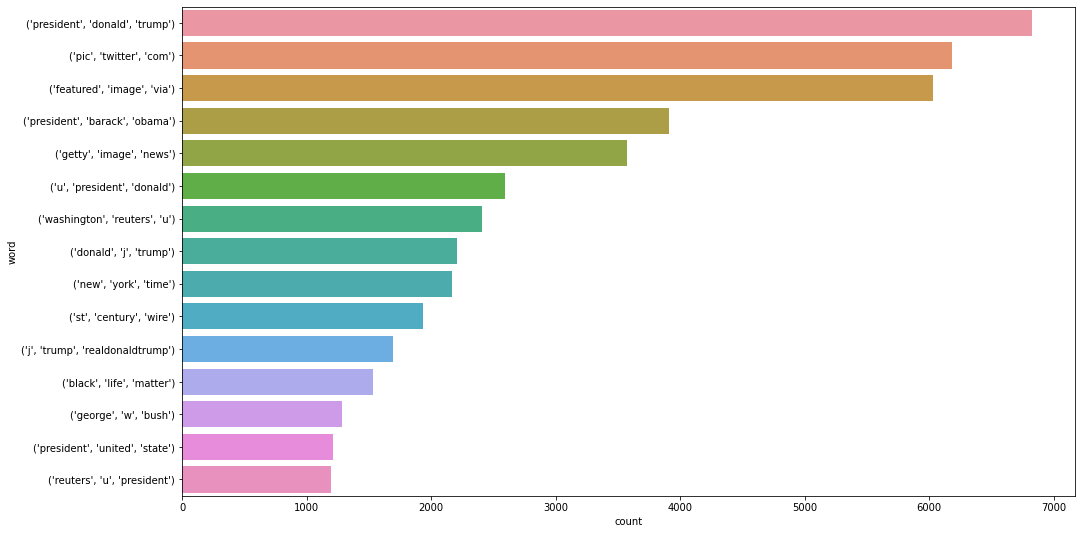

In [21]:
draw_n_gram(string,3)

##### Model Building

In [22]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], random_state=0)

In [23]:
# Keep all news to 300, add padding to news with less than 300 words and truncating long ones
max_features = 10000
maxlen = 300

In [24]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
tokenized_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(tokenized_train, maxlen=maxlen)

In [25]:
tokenized_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(tokenized_test, maxlen=maxlen)

In [26]:
batch_size = 256
epochs = 10
embed_size = 100

In [27]:
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

2022-12-18 10:25:20.990784: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-18 10:25:20.991859: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-18 10:25:21.450254: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-18 10:25:21.451613: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-18 10:25:21.452493: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 300, 128)          117248    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,168,769
Trainable params: 168,769
Non-trainable params: 1,000,000
_________________________________________________________________


In [29]:
history = model.fit(X_train, y_train, validation_split=0.3, epochs=10, batch_size=batch_size, shuffle=True, verbose = 1)

2022-12-18 10:25:27.838246: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
93/93 [==============================] - 299s 3s/step - loss: 0.6939 - accuracy: 0.5437 - val_loss: 0.5323 - val_accuracy: 0.7208
Epoch 2/10
93/93 [==============================] - 296s 3s/step - loss: 0.5889 - accuracy: 0.6384 - val_loss: 0.6768 - val_accuracy: 0.6078
Epoch 3/10
93/93 [==============================] - 288s 3s/step - loss: 0.6880 - accuracy: 0.5374 - val_loss: 0.6876 - val_accuracy: 0.5331
Epoch 4/10
93/93 [==============================] - 288s 3s/step - loss: 0.6480 - accuracy: 0.5957 - val_loss: 0.5480 - val_accuracy: 0.7254
Epoch 5/10
93/93 [==============================] - 287s 3s/step - loss: 0.5193 - accuracy: 0.7257 - val_loss: 1.1231 - val_accuracy: 0.5637
Epoch 6/10
93/93 [==============================] - 285s 3s/step - loss: 0.6507 - accuracy: 0.5889 - val_loss: 0.6542 - val_accuracy: 0.6197
Epoch 7/10
93/93 [==============================] - 284s 3s/step - loss: 0.5737 - accuracy: 0.6805 - val_loss: 0.4945 - val_accuracy: 0.7500
Epoch 8/10
93

In [30]:
print("Accuracy of the model on Training Data is - " , model.evaluate(X_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

1053/1053 [==============================] - 160s 152ms/step - loss: 0.5341 - accuracy: 0.7112
Accuracy of the model on Training Data is -  71.12226486206055 %
351/351 [==============================] - 53s 150ms/step - loss: 0.5333 - accuracy: 0.7130
Accuracy of the model on Testing Data is -  71.29621505737305 %


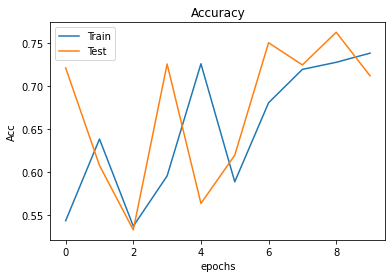

In [31]:
plt.figure()
plt.plot(history.history["accuracy"], label = "Train")
plt.plot(history.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

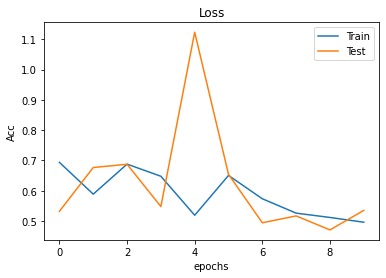

In [32]:
plt.figure()
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [33]:
pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, pred, target_names = ['Fake','Real']))

              precision    recall  f1-score   support

        Fake       1.00      0.45      0.62      5858
        Real       0.62      1.00      0.77      5367

    accuracy                           0.71     11225
   macro avg       0.81      0.72      0.69     11225
weighted avg       0.82      0.71      0.69     11225



##### Saving Model and Tokenizer

In [34]:
model.save("lstm_classifier.h5", include_optimizer=False)

In [40]:
tokenized_test = tokenizer.texts_to_sequences(["WASHINGTON (Reuters) - U.S. President Donald Trump signed Republicansâ€™ massive $1.5 trillion tax overhaul into law on Friday, cementing the biggest legislative victory of his first year in office, and also approved a short-term spending bill that averts a possible government shutdown. Trump said he wanted to sign the tax bill before leaving Washington on Friday for his Mar-a-Lago estate in Florida, rather than stage a more formal ceremony in January, so he could keep his promise to finish work before Christmas. â€œI didnâ€™t want you folks to say I wasnâ€™t keeping my promise. Iâ€™m keeping my promise,â€ he told reporters in the White House. The two pieces of legislation represent Trumpâ€™s most significant accomplishment with Congress since taking office in January, as well as a sign of what awaits when he returns from Florida after the Christmas holiday. The tax package, the largest such overhaul since the 1980s, slashes the corporate rate from 35 percent to 21 percent and temporarily reduces the tax burden for most individuals as well. Trump praised several companies that have announced employee bonuses in the wake of the billâ€™s passage, naming AT&T, Boeing, Wells Fargo, Comcast  and Sinclair Broadcast Group. â€œCorporations are literally going wild over this,â€ he said.      Democrats had opposed the bill as a giveaway to the wealthy that would add $1.5 trillion to the $20 trillion national debt during the next decade. The spending bill extends federal funding through Jan. 19, largely at current levels. It does nothing to resolve broader disputes over immigration, healthcare and military spending. Republicans also are divided over whether to follow up their sweeping overhaul of the U.S. tax code with a dramatic restructuring of federal benefit programs. House Speaker Paul Ryan has said he would like to revamp welfare and health programs but Senate Republican Leader Mitch McConnell told National Public Radio on Monday that he was not interested in cutting those programs without Democratic support. Trumpâ€™s year also closes with significant turnover of many top staffers who had been in the White House since early in his term. On Friday, the White House confirmed Deputy Chief of Staff Rick Dearborn and Jeremy Katz, who worked under White House economic adviser Gary Cohn, were leaving. "])
X_test = pad_sequences(tokenized_test, maxlen=maxlen)
pred = model.predict(X_test)
pred

array([[0.74508315]], dtype=float32)

In [41]:
tokenized_test = tokenizer.texts_to_sequences(["In the wake of yet another court decision that derailed Donald Trump s plan to bar Muslims from entering the United States, the New York Times published a report on Saturday morning detailing the president s frustration at not getting his way   and how far back that frustration goes.According to the article, back in June, Trump stomped into the Oval Office, furious about the state of the travel ban, which he thought would be implemented and fully in place by then. Instead, he fumed, visas had already been issued to immigrants at such a rate that his  friends were calling to say he looked like a fool  after making his broad pronouncements.It was then that Trump began reading from a document that a top advisor, noted white supremacist Stephen Miller, had handed him just before the meeting with his Cabinet. The page listed how many visas had been issued this year, and included 2,500 from Afghanistan (a country not on the travel ban), 15,000 from Haiti (also not included), and 40,000 from Nigeria (sensing a pattern yet?), and Trump expressed his dismay at each.According to witnesses in the room who spoke to the Times on condition of anonymity, and who were interviewed along with three dozen others for the article, Trump called out each country for its faults as he read: Afghanistan was a  terrorist haven,  the people of Nigeria would  never go back to their huts once they saw the glory of America, and immigrants from Haiti  all have AIDS. Despite the extensive research done by the newspaper, the White House of course denies that any such language was used.But given Trump s racist history and his advisor Stephen Miller s blatant white nationalism, it would be no surprise if a Freedom of Information Act request turned up that the document in question had the statements printed inline as commentary for the president to punctuate his anger with. It was Miller, after all, who was responsible for the  American Carnage  speech that Trump delivered at his inauguration.This racist is a menace to America, and he doesn t represent anything that this country stands for. Let s hope that more indictments from Robert Mueller are on their way as we speak.Featured image via Chris Kleponis"])
X_test = pad_sequences(tokenized_test, maxlen=maxlen)
pred = model.predict(X_test)
pred

array([[0.00084819]], dtype=float32)

In [43]:
tokenized_test = tokenizer.texts_to_sequences(["A new animatronic figure in the Hall of Presidents at Walt Disney World was added, where every former leader of the republic is depicted in an  audio-animatronics show.  The figure which supposedly resembles Jon Voight Donald Trump was added to the collection and it s absolutely horrifying. The internet noticed that, too.Here s a few more pictures of the Donald Trump animatronic. #HallOfPresidents pic.twitter.com/a45En9Jwys  WDW News Today (@WDWNT) December 19, 2017Trump robot in the Hall of Presidents looks like a 71-year-old Chucky doll. pic.twitter.com/yLCBmhpNvG  John Cohen (@JohnCohen1) December 19, 2017Breaking: 7 Disney Princesses and a Storm Trooper have come forward alleging Hall of Presidents Trump made lewd comments to them  Brohibition Now (@OhNoSheTwitnt) December 19, 2017Trump s animatronic figure for the Disney Hall of Presidents looks like it was carved out of Play-Doh and left out in the Florida heat, where it was discovered by a dying albino squirrel who settled atop its head and has been left there to decompose. pic.twitter.com/3vMZUTEylx  Elizabeth M. (@_ElizabethMay) December 19, 2017In a time w/ so many heavy items, thank you to Disney for the laugh. They did so much so well in the @realDonaldTrump animatronic.  Little hands, check   Absurdly long tie, check   Horrifying face, checkmateWhen Trump is impeached, can they move this to the Haunted Mansion? https://t.co/XrOvu32EV8  State of Resistance (@AltStateDpt) December 19, 2017all the other presidents in Disney s new Hall of Presidents look like they can t believe Donald Trump is president either pic.twitter.com/eMP9UX1bM8  Matt Binder (@MattBinder) December 18, 2017Disney unveiled Trump figure at the Hall of Presidents. To save production costs, they pulled the animated hands off of a retired figurine from the Its a Small World ride.  Tim Hanlon (@TimfromDa70s) December 19, 2017The best part of Donald Trump being in Disney s Hall of Presidents will be when they remove him from the Hall of Presidents and put him in the Pirates of the Caribbean ride s jail. pic.twitter.com/XViyKFQCET  Rex Huppke (@RexHuppke) December 19, 2017Comment today by local news channel anchor in Orlando:  Donald Trump robot just added to Disney s Hall of Presidents. I hope they programmed all the former presidents to not roll their eyes and shake their heads while he s talking.  Mark Hertling (@MarkHertling) December 19, 2017NPR: Disney World Adds Trump Animatronic Figure, But Likeness Is Lacking. But who REALLY wants to look at an accurate Donald? The man is about as presidential looking as a fucking Pokemon. https://t.co/HFYJRkefJ1  Stephen (@Harvest_This) December 19, 2017Could we put the animatronic version in the White House and the  real  one in Disney World? Asking for 7.6 billion people and the future of the planet. https://t.co/65FhbQHuV4 #Disney #Trump #JonVoight  David Schmid (@DavidSchmid1) December 19, 2017We re pretty sure Disney is trolling Trump.Image via Twitter."])
X_test = pad_sequences(tokenized_test, maxlen=maxlen)
pred = model.predict(X_test)
pred[0][0]

0.0011246507

In [46]:
tokenizer_save_file = "lstm_tokenizer.pkl"
with open(tokenizer_save_file, "wb") as file:
    pickle.dump(tokenizer, file)

In [48]:
model.save("lstm_tokenizer.h5", include_optimizer=False)